# Lab 2. Numerical differentiation

High Performance Computing, Innopolis University, Spring 2018

In [2]:
# Import common modules and set up cute plots
import math
import numpy as np
from typing import List, Iterable
from IPython.core.display import HTML, display

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

## Optimal step size

Let's recall some theory.

If we compute f' as (f(x+h)-f(x))/h, then we have two sources of error:
- Round-off error: `2**(2-t) * abs(f(x))/h`
- Approximation error (also called truncation error): `M2 * h/2`

Here, t is the length of the mantissa (in bits), M2 is the maximum of the second derivative of f, and h is the differentiation step.

Let's check this theory with the snippet below:

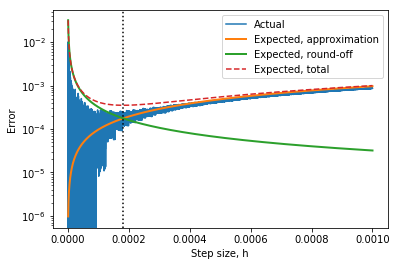

In [3]:
f = lambda x: np.sin(x)**2  # The function itself
df = lambda x: np.sin(2*x)  # It's first (analytical) derivative
d2f = lambda x: 2*np.cos(x)  # Second (analytical) derivative
dtype, m_len = np.float32, 23  # Floating-point type used, and corresponding mantissa length in bits

hs = np.linspace(1e-6,1e-3,10000, dtype=dtype)  # Different step sizes to test
x = dtype(np.pi/12)  # Point at which we compute the derivative

# Round-off error
err_r = 2**(2-m_len) * np.abs(f(x)) / hs
# Approximation error
err_a = np.abs(d2f(x)) * hs / 2  # We assume that change in f'' is insignificant on [x, x+h]
# Actual error
err_e = (f(x+hs)-f(x))/hs - df(x)

h_opt = np.sqrt(2**(3-m_len) * np.abs(f(x) / d2f(x)))

plt.plot(hs, err_e, label='Actual')
plt.plot(hs, err_a, label='Expected, approximation', lw=2)
plt.plot(hs, err_r, label='Expected, round-off', lw=2)
plt.plot(hs, err_a+err_r, '--', label='Expected, total')
plt.axvline(h_opt, ls=':', color='k')
plt.legend()
plt.xlabel('Step size, h')
plt.ylabel('Error')
plt.semilogy()
plt.show()

We see that total expected error (red, dashed) pretty accurately estimates the actual error (blue). We can also see which component — approximation (orange) or round-off (green) — contributes mainly for each step size. Please, keep in mind that Y-axis is logarithmic.

The black dashed vertical line indicate computed optimal value of step size.

If you experiment with different points, you can see that the estimation is not always working very good.
For example, the error is overestimated significantly at x=π/3. But for most points, the actual and expected errors are pretty close.

We can also see that actual error varies wildly for small step sizes when it is determined by round-off error. This is to be expected: the round-off error is very stochastic in nature, and errors on two consecutive steps can either cancel or amplify each other. When doing the theoretical analysis, we always assume worst case.

## Higher order approximations

Above we've studied the theoretical errors of first-order differentiation method. Let's compare it with higher-order methods on some real-ish data.

Imagine we're measuring some signal and get a bunch of values corresponding to different time stamps.
We will use the sine function as "original" signal, and add some noise to simulate measurement uncertainty.

Then we will compute derivative on our "measured" data, and compare different schemes.

For simplicity, we will drop first and last measurements when making comparison, because calculating derivatives in them is a bit more complicated

In [33]:
def get_errors(e, n):
    """
    This function computes theoretical and experimental errors for three differentiation schemes.
    e -- noise amlitude in input data
    n -- number of measurements of input data
    return -- three pairs of error values for three different schemes. See code.
    """
    t = np.linspace(0, 2*np.pi, n)  # Timestamps (our grid)
    x_clean = np.sin(t)
    x_noise = (np.random.random(size=t.shape) - 0.5) * 2*e
    x = x_clean + x_noise  # Generated noisy signal

    dx_true = np.cos(t)  # "True" derivative of original, clean signal
    # Preallocate arrays for computed derivatives
    dx_1 = np.zeros_like(x)
    dx_2 = np.zeros_like(x)
    dx_3 = np.zeros_like(x)

    h = t[1] - t[0]  # Grid size = time between measurements

    dx_1[:-1] = (x[1:] - x[:-1]) / h  # (f(x+h) - f(x)) / h
    dx_2[1:-1] = (x[2:] - x[:-2]) / (2*h)  # (f(x+h) - f(x-h)) / 2h
    dx_3[:-2] = (4*x[1:-1] - 3*x[:-2] - x[2:]) / (2*h)  # (4f(x+h) - 3f(x) - f(x+2h)) / 2h

    e1 = np.abs(dx_1 - dx_true)[2:-2].max()  # Dropping first and last points
    e1_th = 0.5*h + 2*e/h  # Theoretical estimate
    e2 = np.abs(dx_2 - dx_true)[2:-2].max()
    e2_th = h**2/6 + e/h
    e3 = np.abs(dx_3 - dx_true)[2:-2].max()
    e3_th = h**2/3 + 4*e/h
    return np.array([e1, e1_th, e2, e2_th, e3, e3_th])

Let's see how different methods react on different step size.
We won't alter step size directly. Instead we will change a number of samples, i.e., how many measurements of our function we've taken.

The markers in the plot represent experimentally measured values; continuous lines represent theoretical estimates.

/home/aland/Dropbox/Teaching/HPC2018/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


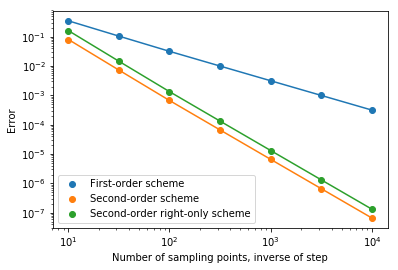

In [58]:
e = 1e-18  # Max. measurement error
ns = 10.0 ** np.arange(1.0, 4.1, 0.5)  # Possible sampling values
errs = np.array([get_errors(e, n) for n in ns])

plt.scatter(ns, errs[:, 0], label='First-order scheme')
plt.scatter(ns, errs[:, 2], label='Second-order scheme')
plt.scatter(ns, errs[:, 4], label='Second-order right-only scheme')
plt.gca().set_prop_cycle(None)
plt.plot(ns, errs[:, 1])
plt.plot(ns, errs[:, 3])
plt.plot(ns, errs[:, 5])
plt.legend()
plt.loglog()
plt.xlabel('Number of sampling points, inverse of step')
plt.ylabel('Error')
plt.show()

We see that, for very small error, decreasing step size (increasing number of samples) improves precision for all schemes.

But for large errors this is not true: if measurements are _too_ noisy, taking _too_ many of them hurts precision. And, of course, we see that different schemes have different critical points, just as their theoretical analysis has predicted.

/home/aland/Dropbox/Teaching/HPC2018/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


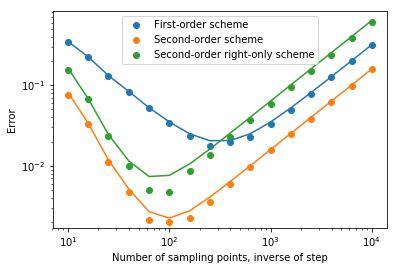

In [59]:
e = 1e-4  # Max. measurement error
ns = 10.0 ** np.arange(1.0, 4.1, 0.2)  # Possible sampling values
errs = np.array([get_errors(e, n) for n in ns])

plt.scatter(ns, errs[:, 0], label='First-order scheme')
plt.scatter(ns, errs[:, 2], label='Second-order scheme')
plt.scatter(ns, errs[:, 4], label='Second-order right-only scheme')
plt.gca().set_prop_cycle(None)
plt.plot(ns, errs[:, 1])
plt.plot(ns, errs[:, 3])
plt.plot(ns, errs[:, 5])
plt.legend()
plt.loglog()
plt.xlabel('Number of sampling points, inverse of step')
plt.ylabel('Error')
plt.show()

Now let's try to fix sampling rate and vary measurement error.

As expected, the first-order scheme hits plateu after rather early, and does not show increased precision with decreased input error, because it is bounded by step size. Both second-order schemes also reach a plateu, but much further to the left.

And if the data is bad enough, the choice of method does not play too big of a role. The first-order method even has lower error than on of the second-order ones.

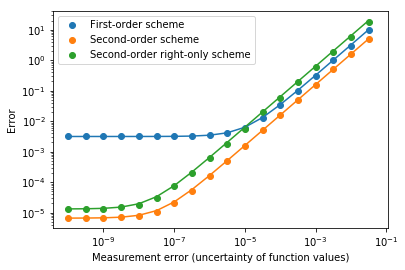

In [46]:
n = 500
es = 10.0**(np.arange(-10, -1, 0.5))
errs = np.array([get_errors(e, n) for e in es])

plt.scatter(es, errs[:, 0], label='First-order scheme')
plt.scatter(es, errs[:, 2], label='Second-order scheme')
plt.scatter(es, errs[:, 4], label='Second-order right-only scheme')
plt.gca().set_prop_cycle(None)
plt.plot(es, errs[:, 1])
plt.plot(es, errs[:, 3])
plt.plot(es, errs[:, 5])
plt.legend()
plt.loglog()
plt.xlabel('Measurement error (uncertainty of function values)')
plt.ylabel('Error')
plt.show()

## Symbolic and automatic differentiation

Above we dealt with numerical differentiation, _i.e._, using finite differences methods to approximately find 
the value of the derivative.

But computers can do more. Symbolic differentiation allows one to find the value of the derivative by automatically doing the same operations you did in Calculus course, like looking up the derivatives of fundamental functions, applying chain rule etc.

_Note_: [Symbolic](https://en.wikipedia.org/wiki/Computer_algebra) and [automatic](https://en.wikipedia.org/wiki/Automatic_differentiation) differentiations are [fundamentally different](https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/#ad-is-not-symbolic-differentiation), but I don't distinguish them here. Tensorflow, used below, employs automatic differentiation.

This Tensorflow example that calculates the derivative of `sin(x)**2` for x=π/17.
We also compute the value using manually-derived derivative, and using double-precision numerical differentiation.

In [3]:
x0 = np.pi / 17  # The point

print('Analytical: {:.17f}'.format(np.sin(2*x0)))

import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder(tf.float64)
y = tf.square(tf.sin(x))
dy = tf.gradients([y], [x])[0]
with tf.Session() as sess:
    print('Tensorflow: {:.17f}'.format(sess.run(dy, feed_dict={x: [x0]})[0]))

# Finding the optimal step for numerical differentiation
h_opt = np.sqrt(2**(3-52) * np.abs(np.sin(x0)**2 / (2*np.cos(x0)))) 
print('Numerical : {:.17f}'.format((np.sin(x0+h_opt)**2 - np.sin(x0)**2)/h_opt))

Analytical: 0.36124166618715292
Tensorflow: 0.36124166618715298
Numerical : 0.36124166985988576
